In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
import math
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, DistanceMetric
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt
import colorcet as cc
from sklearn.covariance import EllipticEnvelope 
#
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
import gower
from scipy.spatial.distance import hamming

# Filter all warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# # list of 8 applications in dataset
classes = ['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station',\
           'Smart Things', 'Amazon Echo', 'Samsung SmartCam','TP-Link Day Night Cloud camera', 'Triby Speaker',\
              'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame','Belkin wemo motion sensor',\
                     'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone',\
                            'MacBook', 'Withings Aura smart sleep sensor','Light Bulbs LiFX Smart Bulb',\
                            'Blipcare Blood Pressure meter','iHome', 'Insteon Camera', 'Android Phone', 'Laptop']
classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [3]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test):
    array_of_indices = []
    unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports

"""
Function to calculate the score of the model
"""
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    # model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
    #                                 random_state=42, bootstrap=False)
    
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

def get_model(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

    return model

def get_x_y_flow(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def get_x_y_flow_binary(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

"""
Function to calculate the score of the model in terms of Flow-Level metric
"""
def expand_rows_and_get_scores(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    ####
    expanded_y_true_Dropcam = []
    expanded_y_pred_Dropcam = []
    #
    expanded_weights_Dropcam = []
    
    for true_label, pred_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
                 
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL, expanded_y_true, expanded_y_pred, expanded_weights

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [4]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [5]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [6]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    # for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
    #     plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    for x_axis_val, y_axis_val, color in zip(x_axis_values, y_axis_values, colors):
        plt.plot(x_axis_val, y_axis_val, 'g*-', color=color, linewidth=1.5, markersize=4)
    plt.plot(x_axis_val, [0.7 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.plot(x_axis_val, [0.5 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.xticks(rotation=90)
    plt.title(fig_title)
    plt.legend()
    plt.show()

In [7]:
#### PCFI - Per Class Feature Importance ####
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()

def f_entropy(v):
    return sps.entropy(pk=v)

def f_misclassification(v):
    p = v/v.sum()
    
def calcImportanceMatrix(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    for dec_tree in rf_clf.estimators_:

        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        # print('NODE PRED:', node_pred)
        leaves_class_index = node_pred[is_leaves]
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            current_i = parent_node_ind[leaf_i]
            # print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]
                
                # print(leaves_class_index, current_values_class)
                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                #print('next current is ', current_i)
        # print(tree_importances.shape)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])
        # print(importance_matrix)

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

## WITHOUT LIMITATION

#### N=3 RF(23, 32,15) - Generate the chosen model

In [8]:
# Load Train and Test data
time = "normal"
npkts = 3
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
###########
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)

###########
#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########

all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)

# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)
#
train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)
#
train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])
#
test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))
#
train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)
#
train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])

# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)
#
test_data['weight'] = np.where(test_data['sample_nature'] == 'flw', (test_data['pkt_count'] - npkts + 1)/test_data['pkt_count'], 1/test_data['pkt_count'])
weight_of_samples_test = list(test_data['weight'])

Num Labels:  24


In [9]:
## The model (the best) chosen for analysis
depth = 23
n_tree = 32
no_feats = 15
leaf = 500
# feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
feats = ['tcp.window_size_value', 'ip.len', 'udp.length', 'dstport', 'ip.ttl', 'tcp.hdr_len', 'srcport', 'Packet Length Total', 'Packet Length Mean', 'Max Packet Length', 'tcp.flags.rst', 'Flow IAT Max', 'Flow IAT Mean', 'Flow Duration', 'Flow IAT Min']
#
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights  = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)


0.7923829498103626 0.9081743142574276 0.9065605200052853


#### Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=list(expanded_y_true), y_pred=expanded_y_pred, sample_weight=expanded_weights, labels=list(range(0, len(classes))))
#
# plt.figure(figsize=(50,50))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# fig, ax = plt.subplots(figsize=(30,30))
# disp.plot(ax=ax)
# ax.set_xticklabels(classes, rotation=90)
#
# df_cols = ['Class_Name'] + classes
cm_df = pd.DataFrame(columns=classes)

for i in range(0, len(classes)):
    true_label = cm[i]
    cm_df.loc[len(cm_df.index)] = true_label
cm_df.insert(loc=0, column='Class_Name', value=classes)

In [11]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# #
# cm_normalized = []
# for cl_list in cm:
#     if np.sum(cl_list)!=0:
#         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
#     else:
#         cm_normalized.append(np.array(cl_list))
# cm_normalized = np.array(cm_normalized)
# # cm_normalized
# #
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# fig, ax = plt.subplots(figsize=(30,30))
# disp.plot(ax=ax)
# ax.set_xticklabels(classes, rotation=90)

#### Order classes in terms of its scores and PLOT F1-score Per Class

In [12]:
class_names = cl_report_FL.keys()
score_per_class = []
classes_ = []
support_values = []

for c_name in class_names:
    if c_name in classes:
        score_per_class.append(cl_report_FL[c_name]['f1-score'])
        classes_.append(c_name)
        support_values.append(cl_report_FL[c_name]['support'])

classes_.append('IPhone')
score_per_class.append(0)
support_values.append(0)
classes_.append('Blipcare Blood Pressure meter')
score_per_class.append(0.001)
support_values.append(0)
score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class, 'support': support_values})
score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)

In [13]:
cl_report_FL

{'Laptop': {'precision': 0.9718742870348502,
  'recall': 0.9117356017875112,
  'f1-score': 0.9408449097764243,
  'support': 11484.000000007463},
 'Insteon Camera': {'precision': 0.8862300129752665,
  'recall': 0.9967082446122089,
  'f1-score': 0.9382280666886891,
  'support': 6887.999999999669},
 'Samsung SmartCam': {'precision': 0.9768491657545977,
  'recall': 0.9780426157263765,
  'f1-score': 0.9774455264433817,
  'support': 13334.000000004085},
 'Amazon Echo': {'precision': 0.9720873301499645,
  'recall': 0.9616541005851617,
  'f1-score': 0.9668425698571494,
  'support': 4649.0},
 'Samsung Galaxy Tab': {'precision': 0.9022834072332899,
  'recall': 0.8188869800328156,
  'f1-score': 0.8585647765606759,
  'support': 7961.999999998589},
 'Belkin wemo motion sensor': {'precision': 0.9582867324150853,
  'recall': 0.9605670923232106,
  'f1-score': 0.9594255573828422,
  'support': 3281.9999999995284},
 'Netatmo Welcome': {'precision': 0.8861794502402178,
  'recall': 0.9045715353705123,
  'f

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


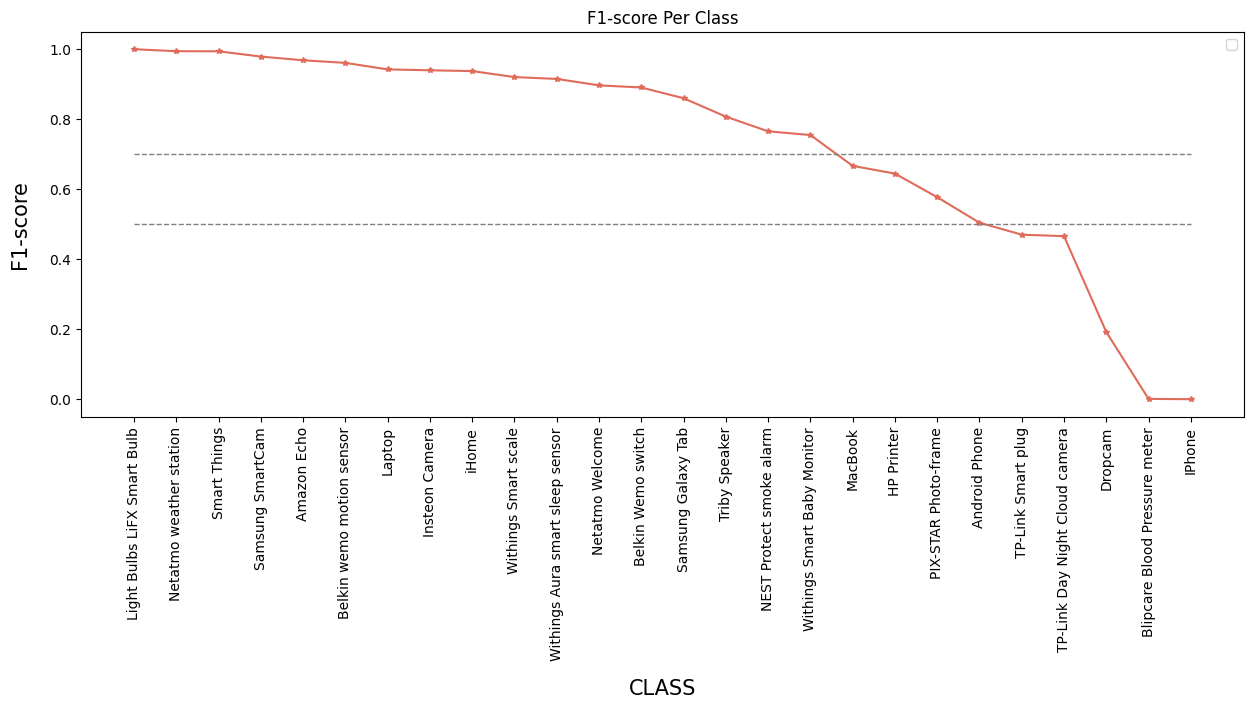

In [14]:
##### TEST
plot_line([score_per_class_df['class'].to_list()], [score_per_class_df['f1_score'].to_list()], [], 'CLASS', 'F1-score', 'F1-score Per Class')

# PCFI
#### Obtaining per-class feature importance

In [15]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)

In [16]:
### Matrix containing feature importances per feature-class pair
imp_mat = calcImportanceMatrix(rf_opt)

In [17]:
#### GET ordered classes and GET their features and feature importances in that order
imp_mat_ordered = []
score_per_class_df['f1_score'] = score_per_class_df['f1_score']*100
classes_ordered_main_model = score_per_class_df['class'].to_list()
class_scores_ordered = score_per_class_df['f1_score'].to_list()

for cl in classes_ordered_main_model:
    ind_of_class = classes.index(cl)
    imp_mat_ordered.append(imp_mat[ind_of_class])
    
## 2 classes which are not in TEST SET
# classes_ordered.append('IPhone')
# class_scores_ordered.append(0)
# imp_mat_ordered.append(imp_mat[classes.index('IPhone')])
# classes_ordered.append('Blipcare Blood Pressure meter')
# class_scores_ordered.append(1)
# imp_mat_ordered.append(imp_mat[classes.index('Blipcare Blood Pressure meter')])

In [18]:
len(classes_ordered_main_model)

26

In [19]:
feature_names = feats

# Outlier Detection

## Generate the data and detect outliers
#### With Plots

In [20]:
def take_derivative(class_name, data_dict, threshold):

    imp_list = data_dict[class_name]
    # print(imp_list)
    # Example CDF data
    x = np.arange(len(imp_list))
    y = imp_list

    # print(len(x))
    # print(len(y))

    # Compute the derivative
    dy_dx = np.gradient(y, x)
    print(dy_dx)
    selected_point_index = len(imp_list)-1
    selected_point = dy_dx[selected_point_index]
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0]
                selected_point = dy_dx[selected_point_index]
    print(selected_point, selected_point_index)
    #
    # Plot the CDF and its derivative
    plt.figure()
    
    plt.scatter(selected_point_index, imp_list[selected_point_index[0] ], color='red', s=45)
    plt.scatter(selected_point_index, dy_dx[selected_point_index[0] ], color='red', s=45)
    plt.plot(x, y, label='Cumulative Importance')
    plt.plot(x, dy_dx, label='Derivative of Cumulative Importance: ' + str(class_name))
    plt.xlabel('Classes')
    plt.ylabel('Importance')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
max_exponent = 709
x_scores = []
y_importances = []
c_name = []
f_name = []
exp_values = []
normal_importances = []
for c in range(0, len(classes_ordered_main_model)):
    sum_exp_values = 0
    exp_values_per_class = []
    for f in range(0, len(feature_names)):
        c_name.append(classes_ordered_main_model[c])
        f_name.append(feature_names[f])
        x_scores.append(class_scores_ordered[c]/100)
        normal_importances.append(np.array(imp_mat_ordered)[c,f])
        try:
            if(np.array(imp_mat_ordered)[c,f] == 0):
                ### If the values is too big for math.exp
                y_importances.append(max_exponent)
                # print('first set')
            else:
                y_importances.append((1/(np.array(imp_mat_ordered)[c,f]*100)))
            exp_values.append(math.exp(y_importances[-1]))
        except:
            ### If the y_importance values is too big for math.exp
            y_importances[-1] = max_exponent
            exp_values.append(math.exp(y_importances[-1]))
            
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'y_importances': y_importances, 'exp_values': exp_values, 'normalized_exp': normalized_exp_values,  'density': density})
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values, 'log10_based_exp': log10_based,'normalized_exp': normalized_exp_values, 'sum_of_importances_log10':sum_of_importances_log10, 'inverse_exp': inverse_exp})
density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values})


density_df['FINAL'] = density_df['exp_values']/(density_df['normal_importances'])
density_df['normal_importances_100'] = density_df['normal_importances']*100
density_df['Feature'] = density_df['f_name'].replace(feature_names, range(len(feature_names)))
        

In [22]:
prop_increase_dict = {}
cum_increase_dict = {}

In [23]:
### RELATIVE rate of change
def flag_outliers(df, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df['c_name'].unique()[0])
    # print('last_y', last_y)
    last_decrease = df.loc[0]['ccum_sum']-df.loc[1]['ccum_sum']
    # print('last decrease', last_decrease)
    decreases = [last_decrease]
    rel_decrease = [1]
    for index,row in df[2:].iterrows():
        curr_decrease = last_y - row['ccum_sum']
        # print('curr_decrease', curr_decrease)
        decreases.append(curr_decrease)
        rel_improvement =  last_decrease / curr_decrease
        rel_decrease.append(rel_improvement)
        if rel_improvement < th:
            cutoff.append(index)
        last_y = row['ccum_sum']
        last_decrease = curr_decrease
    # # PLOT
    # f, ax1 = plt.subplots()
    # ax1.plot(decreases, color='C0', label='decreases')
    # ax2 = ax1.twinx()
    # ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    # ax1.set_title(df['c_name'].unique()[0])
    # plt.legend()
    # plt.show()
    if not cutoff:
        cutoff.append(index)
    # print(f'found cutoff: {cutoff[0]}!')
    df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [24]:
### RELATIVE rate of change
def flag_outliers_with_cost(df, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    # df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1))
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df)
    cost_values = [i/15 for i in range(1, 16)]
    total_gain_list = []
    ##
    for index,row in df.iterrows():
        ##
        # print('Feature NO: ', index, 'Total COST: ', cost_values[index], 'Total GAIN: ', row['ccum_sum'], 'DIFF: ', row['ccum_sum'] - cost_values[index])
        # print('Feature NO: ', count_feat, 'UI    :', math.log(row['ccum_sum']) - math.log(count_feat/(15)))
        ### First Option
        total_gain =  row['ccum_sum'] - cost_values[index]
        ###
        ### Second Option
        # rel_improvement_cost = 0.45*rel_improvement - 0.55*(count_feat)/(15)
        ###
        ### Third Option
        # rel_improvement_cost = rel_improvement - 1.2*(count_feat)/(15)
        # print((count_feat-1)/(count_feat))
        
        # rel_improvement_cost =  rel_improvement - 0.8*((count_feat-1)/(count_feat))
        ###
        
        # rel_improvement_cost = rel_improvement*(math.log(row['ccum_sum']) - math.log(count_feat/(15)))
        total_gain_list.append(total_gain)
        # print('Rel_imp: ', rel_improvement, 'Rel_imp cost: ', rel_improvement_cost)
        # print(rel_improvement_cost)
        # if rel_improvement_cost <= 0:
        #     cutoff_cost.append(index)
        # count_feat = count_feat + 1
        ##
    ##
    # if not cutoff_cost:
    #     cutoff_cost.append(index)
    # print(f'found cutoff COST: {cutoff_cost[0]}!')
    ##
    ## Find the 
    total_gain_list = np.array(total_gain_list)
    index_cost = np.argmax(total_gain_list)
    
    # f, ax1 = plt.subplots()
    # ax1.plot(total_gain_list, color='C0', label='Total gain')
    # # ax2 = ax1.twinx()
    # # ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    # ax1.set_title(df['c_name'].unique()[0])
    # plt.legend()
    # plt.show()
    
    df['outlier'].iloc[[i for i in range(index_cost+1)]]=False
    # print('Number of features to use: ', index_cost)
    # df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [25]:
def flag_inliers(df, threshold=0.05):
    inliers=[]
    df = df.reset_index()
    last_increase = 0
    c_name = df['c_name'].unique()[0]
    prop_increase_dict[c_name] = []
    cum_increase_dict[c_name] = []
    cum_score = 0
    for index,row in df.iterrows():
        if index == 0:
            inliers.append(index)
            last_increase = row['normal_importances']
            cum_score = last_increase
            cum_increase_dict[c_name].append(cum_score)
        else:
            # if (row['normal_importances']/last_increase)<0.6:
            #     break
            # else:
            prop_increase_dict[c_name].append(row['normal_importances']/last_increase)
            last_increase = row['normal_importances']
            cum_score = cum_score + last_increase
            cum_increase_dict[c_name].append(cum_score)
            inliers.append(index)
            
    # Compute the derivative
    y = cum_increase_dict[c_name]
    x = np.arange(len(y))
    dy_dx = np.gradient(y, x)
    # print(y)
    # print(dy_dx)
    # print('--')
    selected_point_index = len(y)-1
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0][0]
    # print(c_name, selected_point, selected_point_index)
    # print(c_name, len(inliers[:selected_point_index + 1]))
    
    df['outlier'].iloc[inliers[:selected_point_index]]=False
    return df.set_index('index', drop=True)

In [26]:
#### CALL flag_outliers per class - RELATIVE RATE of DECREASE
density_df = density_df.assign(outlier=True)
ord_param = 'normal_importances'
density_df = density_df.sort_values(by=ord_param,ascending=False).groupby('c_name', group_keys=False).apply(flag_outliers_with_cost, col_name=ord_param, th=0.65)
#
density_inliers_df = density_df[density_df['outlier']==False]

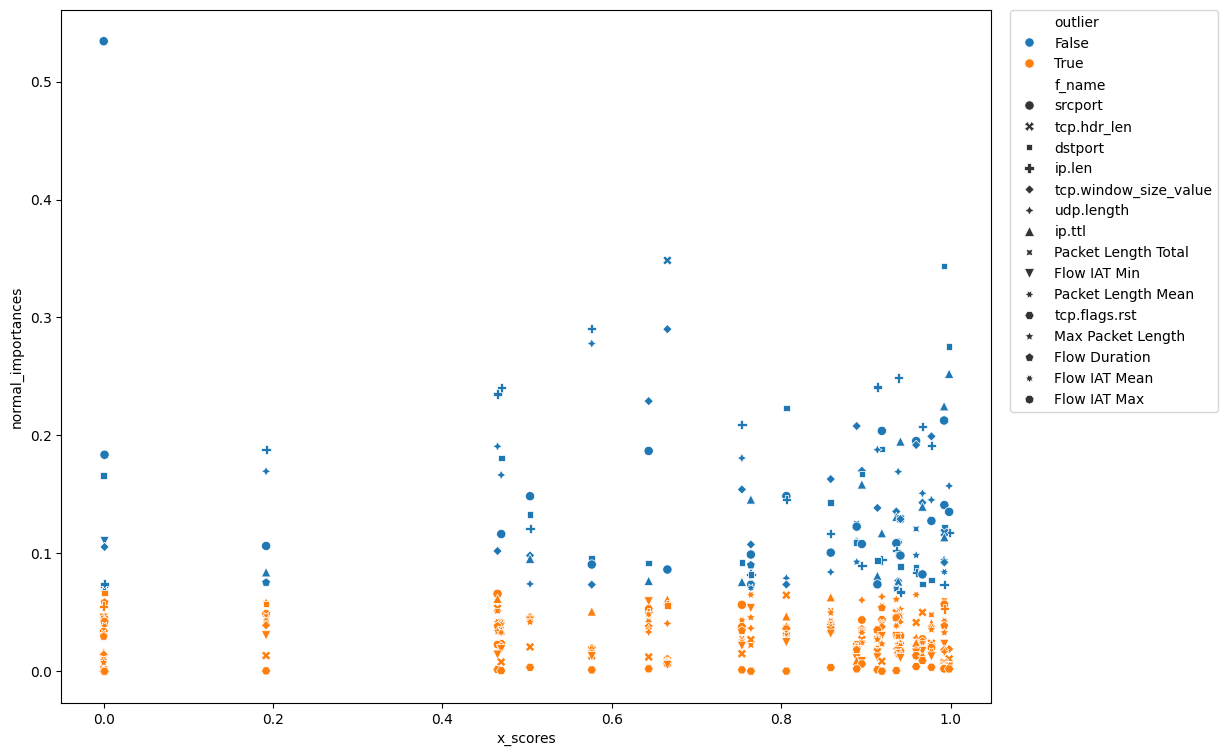

In [27]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_df, x='x_scores', y='normal_importances', ax=ax, hue='outlier', style="f_name", s=45)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlim(0.85, 1)
plt.show()

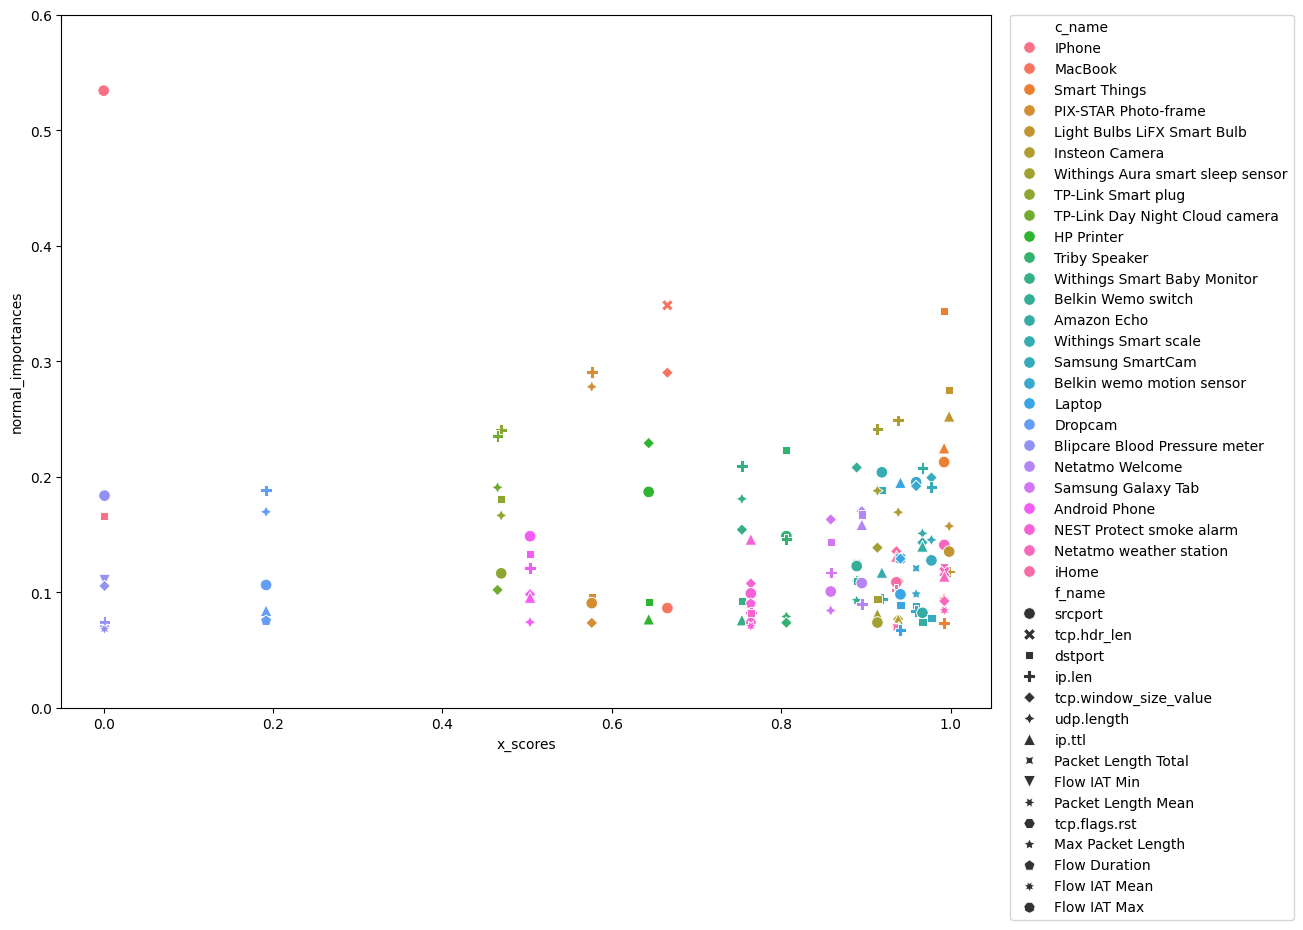

In [28]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_inliers_df, x='x_scores', y='normal_importances', ax=ax, hue='c_name', style="f_name", s=70)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim(0, 0.6)
plt.show()

### Running Hamming Distance on the data obtained after Outlier Detection and RUN CLUSTERING

In [29]:
## Generate Binary Array per class for inlier features
def generate_binary_arrays(df, binary_array_dict):
    binary_array = [0]*len(feats_all)
    
    for i in range(0, len(df['outlier'].to_list())):
        if df['outlier'].to_list()[i] == False:
            binary_array[df['f_name_ord'].to_list()[i]] = 1
    
    # binary_array = [int(i == False) for i in df['outlier'].to_list()]
    df['BinaryArray'] = [binary_array]*len(df['outlier'])
    binary_array_dict[df['c_name'].to_list()[0]] = binary_array
    return df

def generate_feature_importance_arrays(df, binary_array_dict):
    binary_array = [0]*len(feats_all)
    
    for i in range(0, len(df['outlier'].to_list())):
        if df['outlier'].to_list()[i] == False:
            binary_array[df['f_name_ord'].to_list()[i]] = df['normal_importances'].to_list()[i]
    
    # binary_array = [int(i == False) for i in df['outlier'].to_list()]
    df['ImportanceArray'] = [binary_array]*len(df['outlier'])
    binary_array_dict[df['c_name'].to_list()[0]] = binary_array
    return df
    
def assign_clusters(df, clustering_result, classes, clustering_method):
    df[clustering_method] = clustering_result[classes.index(df['c_name'].to_list()[0])]
    return df

def weighted_hamming_dist_by_importance(BinaryArray_dict, ImportanceArray_dict, feats):  
    h_distance = []
    classes_for_distance = BinaryArray_dict.keys()
    for c1 in classes_for_distance:
        distance_c1 = []
        for c2 in classes_for_distance:
            distance = 0
            for feat_ind in range(0, len(feats)):
                if BinaryArray_dict[c1][feat_ind] == BinaryArray_dict[c2][feat_ind]:
                    if BinaryArray_dict[c1][feat_ind] == 1:
                        distance = distance + abs(ImportanceArray_dict[c1][feat_ind] -  ImportanceArray_dict[c2][feat_ind])
                else:
                    distance = distance + 1
            distance_c1.append(distance)
        h_distance.append(distance_c1)
    return h_distance

def weighted_hamming_dist_by_score(distance_matrix, classes_ordered, df):
    weighted_distance_matrix = distance_matrix.copy()
    ## get the classes in order
    classes_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['c_name'].to_list()
    scores_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['x_scores'].to_list()
    
    for i in range(0, len(weighted_distance_matrix)):
        for j in range(0, len(weighted_distance_matrix)):
            first_c_name = classes_ordered[i]
            second_c_name = classes_ordered[j]
            score_difference = abs(scores_ordered[i] - scores_ordered[j]) 
            # print(first_c_name, second_c_name, score_difference, weighted_distance_matrix[i][j])
            weighted_distance_matrix[i][j] = score_difference*weighted_distance_matrix[i][j]
            # print(weighted_distance_matrix[i][j])

    
    return weighted_distance_matrix

def generate_data_to_cluster(classes_to_cluster, classes_ordered):
    classes_ordered_temp = []
    for i in classes_ordered:
        if i in classes_to_cluster:
            classes_ordered_temp.append(i)
    
    data_to_cluster = density_df[density_df['c_name'].isin(classes_to_cluster)]
    data_to_cluster_inliers_df = density_inliers_df[density_inliers_df['c_name'].isin(classes_to_cluster)]
    
    data_to_cluster = data_to_cluster[data_to_cluster['x_scores'] > 0.1]
    data_to_cluster_inliers_df = data_to_cluster_inliers_df[data_to_cluster_inliers_df['x_scores'] > 0.1]
    
    return classes_ordered_temp, data_to_cluster, data_to_cluster_inliers_df

def get_statistics_of_clustering(classes_to_cluster, score_per_class_df, clustering_result):
    ### To get statistics ###
    classes = classes_to_cluster
    score_per_class_df = score_per_class_df[score_per_class_df['class'].isin(classes_to_cluster)]
    all_classes_in_cluster_order = []
    score_per_class_df['Cluster_F1_Score'] = -1 
    score_per_class_df['Cluster'] = list(clustering_result) + [-1]*(len(classes)- len(clustering_result))
    #
    x = score_per_class_df.groupby(by='Cluster')['class'].apply(list).to_dict()
    ## Get the classes in the order of clusters
    for cl in x.values():
        all_classes_in_cluster_order.extend(cl)
    ##
    cluster_info = pd.DataFrame()
    cluster_info['Cluster'] = x.keys()
    cluster_info['Class List'] = x.values()
    cluster_info['Feature List'] = [-1]*len(cluster_info)
    cluster_info['Depth'] =  -1 
    cluster_info['Tree'] =  -1 
    cluster_info['Feats'] =  -1 
    #
    pd.set_option('max_colwidth', None)
    return cluster_info



#### If you want to run clustering algorithm for specific number of clusters:

In [30]:
classes_analy = []
classes_analy_df = pd.DataFrame(classes_analy,  columns=['class'])

In [31]:
classes_ordered, data_to_cluster, data_to_cluster_inliers_df = generate_data_to_cluster(classes_analy, classes_ordered_main_model)

#### Otherwise:

In [32]:
classes_ordered, data_to_cluster, data_to_cluster_inliers_df = generate_data_to_cluster(classes, classes_ordered_main_model)

#### ---

In [33]:
#### CALL generate_binary_arrays to GENERATE BINARY ARRAY STRINGS to check if the feature is inlier or outlier
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feats_all, range(len(feats_all)))
#
BinaryArray_dict = dict.fromkeys(data_to_cluster.sort_values(by='x_scores', ascending=False)['c_name'], None)
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feats_all, range(len(feats_all)))
#
# Generate Binary Array
ord_param = 'f_name_ord'
data_to_cluster = data_to_cluster.sort_values(by=ord_param,ascending=True).groupby('c_name', group_keys=False).apply(generate_binary_arrays, binary_array_dict=BinaryArray_dict)
# 
## Generate Feature Importance Array
ImportanceArray_dict = dict.fromkeys(data_to_cluster.sort_values(by='x_scores', ascending=False)['c_name'], None)
data_to_cluster = data_to_cluster.sort_values(by=ord_param,ascending=True).groupby('c_name', group_keys=False).apply(generate_feature_importance_arrays, binary_array_dict=ImportanceArray_dict)

In [34]:
data_to_cluster['c_name'].unique()

array(['Android Phone', 'NEST Protect smoke alarm',
       'TP-Link Day Night Cloud camera', 'TP-Link Smart plug',
       'Withings Aura smart sleep sensor', 'Samsung Galaxy Tab',
       'Insteon Camera', 'PIX-STAR Photo-frame', 'HP Printer',
       'Netatmo weather station', 'Withings Smart Baby Monitor',
       'Belkin Wemo switch', 'Light Bulbs LiFX Smart Bulb',
       'Belkin wemo motion sensor', 'MacBook', 'Dropcam', 'Smart Things',
       'Laptop', 'Samsung SmartCam', 'Netatmo Welcome', 'Triby Speaker',
       'iHome', 'Amazon Echo', 'Withings Smart scale'], dtype=object)

In [35]:
#### Calculate Hamming Distance weighted with feature importance differences
weighted_hamming_distance = weighted_hamming_dist_by_importance(BinaryArray_dict, ImportanceArray_dict, feats_all)
#### Weighted Hamming Distance multiplied by F1 Score difference
weighted_hamming_distance = weighted_hamming_dist_by_score(weighted_hamming_distance, classes_ordered, data_to_cluster_inliers_df)

In [36]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=11, linkage='complete', affinity='precomputed')
#
clusters_average = model_average.fit_predict(weighted_hamming_distance)
#
# toy_data_df['AGGLOMERATIVE'] = clusters_average
clusters_average

array([ 3,  3,  3,  4, 10,  4,  1,  1,  1,  1, 10,  9,  9,  6,  6,  5,  5,
        2,  2,  0,  0,  8,  8,  7])

In [37]:
data_to_cluster = data_to_cluster.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')
#
data_to_cluster_inliers_df = data_to_cluster_inliers_df.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')

In [38]:
cluster_info = get_statistics_of_clustering(classes, score_per_class_df, clusters_average)
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,-1,"[Blipcare Blood Pressure meter, IPhone]",-1,-1,-1,-1
1,0,"[PIX-STAR Photo-frame, Android Phone]",-1,-1,-1,-1
2,1,"[Laptop, Insteon Camera, iHome, Withings Smart scale]",-1,-1,-1,-1
3,2,"[MacBook, HP Printer]",-1,-1,-1,-1
4,3,"[Light Bulbs LiFX Smart Bulb, Netatmo weather station, Smart Things]",-1,-1,-1,-1
5,4,"[Samsung SmartCam, Belkin wemo motion sensor]",-1,-1,-1,-1
6,5,"[NEST Protect smoke alarm, Withings Smart Baby Monitor]",-1,-1,-1,-1
7,6,"[Samsung Galaxy Tab, Triby Speaker]",-1,-1,-1,-1
8,7,[Dropcam],-1,-1,-1,-1
9,8,"[TP-Link Smart plug, TP-Link Day Night Cloud camera]",-1,-1,-1,-1


In [39]:
#### To get cluster statistics ####
for cluster in list(set(clusters_average)):
    print('\n CLUSTER: ', cluster)
    cluster_df = data_to_cluster_inliers_df[data_to_cluster_inliers_df['Agg_Cluster'] == cluster]
    feat_importances_dict = cluster_df.groupby('f_name')['normal_importances'].mean().to_dict()
    feat_importance_df = pd.DataFrame()
    feat_importance_df['f_name'] = feat_importances_dict.keys()
    feat_importance_df['f_imp'] = feat_importances_dict.values()
    feat_importance_df = feat_importance_df.sort_values(by='f_imp', ascending=False)
    print('Number of Classes: ', len(cluster_df['c_name'].unique()))
    print('Number of Features: ', len(cluster_df['f_name'].unique()))
    print('------')
    print('Classes: ', cluster_df['c_name'].unique())
    print('Features: ', feat_importance_df['f_name'].to_list())
    print('Class Score: ', cluster_df['x_scores'].unique())
    print('------')
    #
    cluster_info.loc[cluster_info['Cluster'] == cluster, 'Feature List'] = str(feat_importance_df['f_name'].to_list())


 CLUSTER:  0
Number of Classes:  2
Number of Features:  6
------
Classes:  ['PIX-STAR Photo-frame' 'Android Phone']
Features:  ['ip.len', 'udp.length', 'srcport', 'dstport', 'ip.ttl', 'tcp.window_size_value']
Class Score:  [0.57633795 0.50347747]
------

 CLUSTER:  1
Number of Classes:  4
Number of Features:  10
------
Classes:  ['Insteon Camera' 'Withings Smart scale' 'Laptop' 'iHome']
Features:  ['udp.length', 'srcport', 'ip.ttl', 'tcp.hdr_len', 'ip.len', 'dstport', 'tcp.window_size_value', 'tcp.flags.rst', 'Packet Length Mean', 'Packet Length Total']
Class Score:  [0.93822807 0.91891892 0.94084491 0.93602732]
------

 CLUSTER:  2
Number of Classes:  2
Number of Features:  5
------
Classes:  ['MacBook' 'HP Printer']
Features:  ['tcp.hdr_len', 'tcp.window_size_value', 'srcport', 'dstport', 'ip.ttl']
Class Score:  [0.66565743 0.6435521 ]
------

 CLUSTER:  3
Number of Classes:  3
Number of Features:  8
------
Classes:  ['Smart Things' 'Light Bulbs LiFX Smart Bulb' 'Netatmo weather sta

In [40]:
type(cluster_info.style.set_properties(**{'text-align': 'left'}))
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,-1,"[Blipcare Blood Pressure meter, IPhone]",-1,-1,-1,-1
1,0,"[PIX-STAR Photo-frame, Android Phone]","['ip.len', 'udp.length', 'srcport', 'dstport', 'ip.ttl', 'tcp.window_size_value']",-1,-1,-1
2,1,"[Laptop, Insteon Camera, iHome, Withings Smart scale]","['udp.length', 'srcport', 'ip.ttl', 'tcp.hdr_len', 'ip.len', 'dstport', 'tcp.window_size_value', 'tcp.flags.rst', 'Packet Length Mean', 'Packet Length Total']",-1,-1,-1
3,2,"[MacBook, HP Printer]","['tcp.hdr_len', 'tcp.window_size_value', 'srcport', 'dstport', 'ip.ttl']",-1,-1,-1
4,3,"[Light Bulbs LiFX Smart Bulb, Netatmo weather station, Smart Things]","['dstport', 'ip.ttl', 'srcport', 'udp.length', 'tcp.hdr_len', 'ip.len', 'tcp.window_size_value', 'Flow IAT Mean']",-1,-1,-1
5,4,"[Samsung SmartCam, Belkin wemo motion sensor]","['tcp.window_size_value', 'srcport', 'udp.length', 'ip.len', 'Packet Length Total', 'Max Packet Length', 'dstport']",-1,-1,-1
6,5,"[NEST Protect smoke alarm, Withings Smart Baby Monitor]","['udp.length', 'ip.len', 'tcp.window_size_value', 'ip.ttl', 'srcport', 'Flow Duration', 'dstport', 'Flow IAT Max', 'Flow IAT Mean']",-1,-1,-1
7,6,"[Samsung Galaxy Tab, Triby Speaker]","['dstport', 'ip.len', 'srcport', 'tcp.window_size_value', 'udp.length']",-1,-1,-1
8,7,[Dropcam],"['ip.len', 'udp.length', 'srcport', 'ip.ttl', 'Flow Duration']",-1,-1,-1
9,8,"[TP-Link Smart plug, TP-Link Day Night Cloud camera]","['ip.len', 'dstport', 'udp.length', 'srcport', 'tcp.window_size_value']",-1,-1,-1


In [41]:
cluster_info.to_csv('cluster_info_W_24CL_11cluster.csv')